# Education and Economic Factors as a Happiness predictors

## 1. Data preparation and cleaning

### 1.1 Import Utilities Library

##### Click "Run long executions" for dataset file prepararion and model training
##### Click "Don't show plots" for disabling graphics
##### Click "Delete offline plots" for deleting all offline plots

In [1]:
%matplotlib inline
from utilities import *

### 1.2 Obtaining the Dataset file

In [2]:
if not button_exec.value:
    DataPreparation.obtainDataFromLocalDBs()

### 1.3 Loading the Dataset file

In [3]:
overall_data = pd.read_csv(DataPreparation.retriveMergedFilePath(),\
                           header=0, index_col=0, skiprows=0, encoding='iso-8859-1')
overall_data.head(5)

,country,year,"Adjusted net enrolment rate, lower secondary, both sexes (%)","Adjusted net enrolment rate, lower secondary, female (%)","Adjusted net enrolment rate, lower secondary, gender parity index (GPI)","Adjusted net enrolment rate, lower secondary, male (%)","Adjusted net enrolment rate, primary, both sexes (%)","Adjusted net enrolment rate, primary, female (%)","Adjusted net enrolment rate, primary, gender parity index (GPI)","Adjusted net enrolment rate, primary, male (%)",...,Wittgenstein Projection: Population in thousands by highest level of educational attainment. Upper Secondary. Total,"Youth illiterate population, 15-24 years, % female","Youth illiterate population, 15-24 years, both sexes (number)","Youth illiterate population, 15-24 years, female (number)","Youth illiterate population, 15-24 years, male (number)","Youth literacy rate, population 15-24 years, both sexes (%)","Youth literacy rate, population 15-24 years, female (%)","Youth literacy rate, population 15-24 years, gender parity index (GPI)","Youth literacy rate, population 15-24 years, male (%)",Happy Planet Index
0,Afghanistan,2012.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.8
1,Afghanistan,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.2
2,Albania,2006.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.1
3,Albania,2009.0,NaN,NaN,NaN,NaN,89.393333,88.698219,0.98508,90.041763,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.9
4,Albania,2012.0,NaN,NaN,NaN,NaN,96.137093,95.353287,0.98445,96.859650,...,NaN,58.875946,4302.0,2533.0,1769.0,99.2314,99.020187,0.99642,99.375977,54.1


### 1.4 Drop columns and rows with %(nulls)>80%

In [4]:
THRESH = 0.2
overall_data = overall_data.dropna(1, thresh=(overall_data.shape[0] * (1 - THRESH)))
overall_data = overall_data.dropna(0, thresh=(overall_data.shape[1] * (1 - THRESH)))
overall_data.head(5)

,country,year,"Enrolment in primary education, both sexes (number)","Enrolment in primary education, female (number)",GDP at market prices (constant 2005 US$),GDP at market prices (current US$),GDP per capita (constant 2005 US$),GDP per capita (current US$),GNI (current US$),"GNI per capita, Atlas method (current US$)",...,"Population, male (% of total)","Population, total","School life expectancy, primary, both sexes (years)","School life expectancy, primary, female (years)","School life expectancy, primary, gender parity index (GPI)","School life expectancy, primary, male (years)",Theoretical duration of pre-primary education (years),Theoretical duration of primary education (years),Theoretical duration of secondary education (years),Happy Planet Index
0,Afghanistan,2012.0,5767543.0,2348306.0,1.935220e+10,2.053654e+10,651.001852,690.842629,2.157185e+10,720.0,...,51.435962,29726803.0,6.53571,5.47000,0.72495,7.54532,4.0,6.0,6.0,36.8
2,Albania,2006.0,222402.0,107004.0,9.771760e+09,8.992642e+09,3265.365622,3005.012903,9.254605e+09,3090.0,...,50.260019,2992547.0,3.98375,3.97433,0.99544,3.99253,3.0,4.0,8.0,42.1
3,Albania,2009.0,236102.0,112399.0,1.150029e+10,1.204421e+10,3928.340828,4114.136545,1.185274e+10,4280.0,...,50.432577,2927519.0,4.80613,4.74382,0.97524,4.86425,3.0,5.0,7.0,47.9
4,Albania,2012.0,206617.0,97583.0,1.240477e+10,1.231978e+10,4277.143310,4247.839852,1.222802e+10,4360.0,...,50.128703,2900247.0,5.16259,5.09023,0.97326,5.23009,3.0,5.0,7.0,54.1
6,Algeria,2006.0,4196580.0,1973901.0,1.446470e+11,1.170270e+11,4285.934521,3467.544740,1.126050e+11,3100.0,...,50.489699,33749328.0,6.40438,6.17532,0.93223,6.62422,1.0,6.0,6.0,45.9


## 2. Data Visualization & Analysis

### 2.1 Most frequent countries appearing in the Dataset

#### 2.1.1 Show counts on globbus map

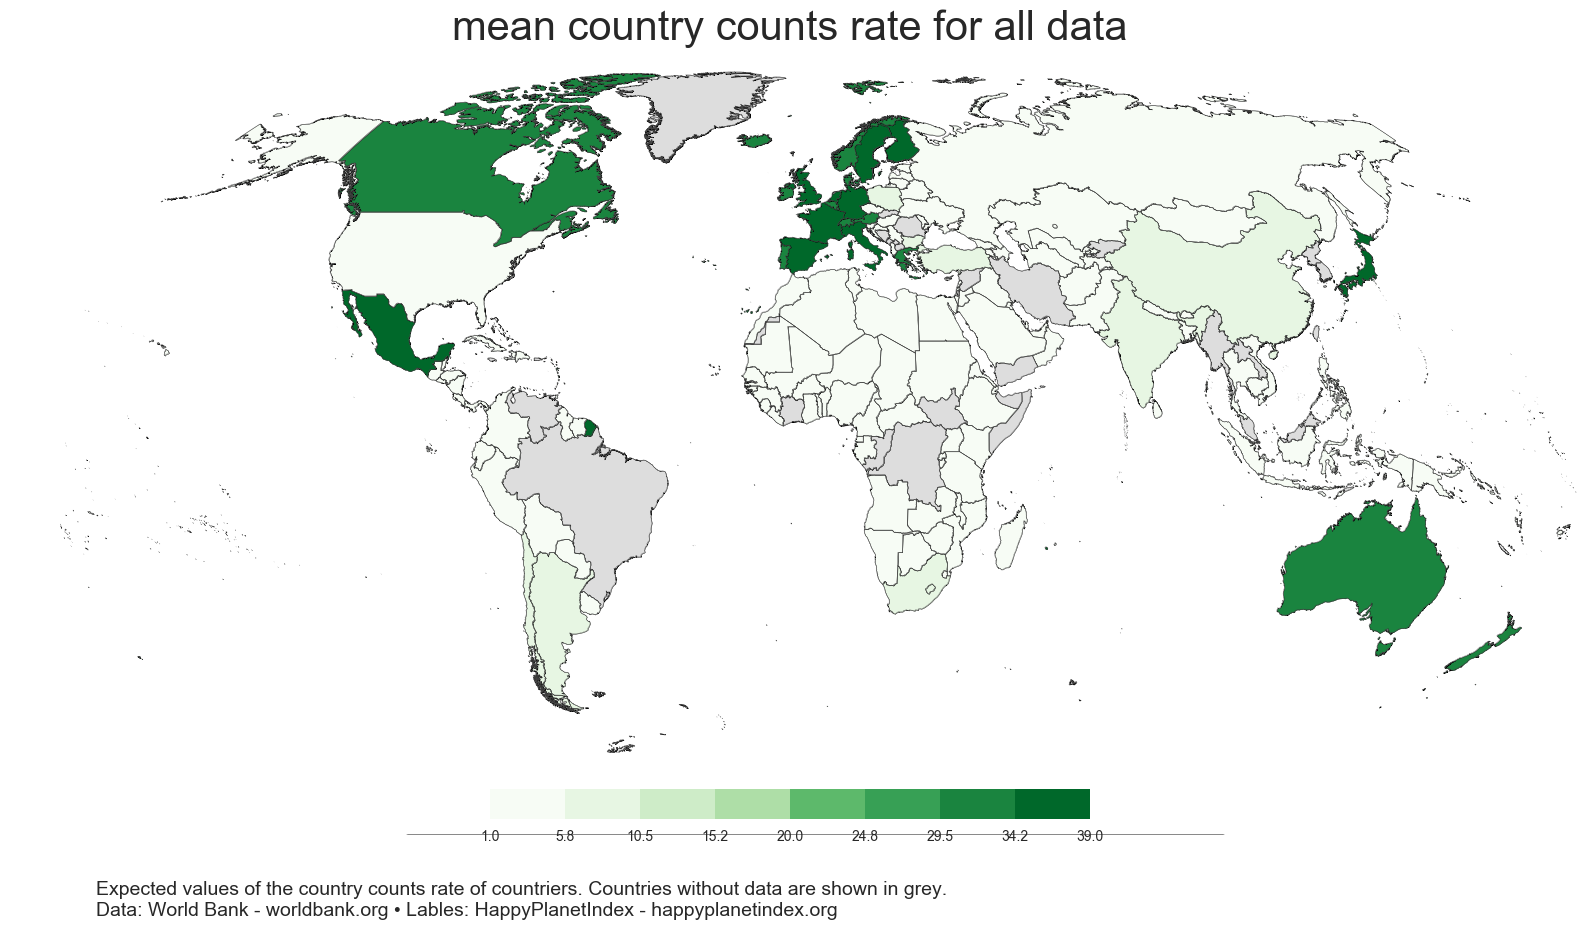

In [5]:
overall_data_country_counts = overall_data.copy()
overall_data_country_counts['country counts'] = \
    overall_data_country_counts.groupby('country')['country'].transform('count')
MapVisualizations.plotDataOnMap(overall_data_country_counts, \
                                feature='country counts', year='mean', show_plot=button_plots.value)

#### 2.1.2 Show counts in table

In [6]:
overall_data_country_counts = overall_data_country_counts\
    .groupby(['country'])[['country','country counts']].mean()
overall_data_country_counts = overall_data_country_counts.sort('country counts', ascending=False)
overall_data_country_counts.reset_index(inplace=True)
overall_data_country_counts[['country','country counts']].head(10)

,country,country counts
0,Spain,39
1,United Kingdom,39
2,Finland,39
3,Germany,39
4,Mexico,39
5,Netherlands,39
6,Sweden,39
7,Italy,39
8,Japan,39
9,France,39


### 2.2 Data distribution over the years

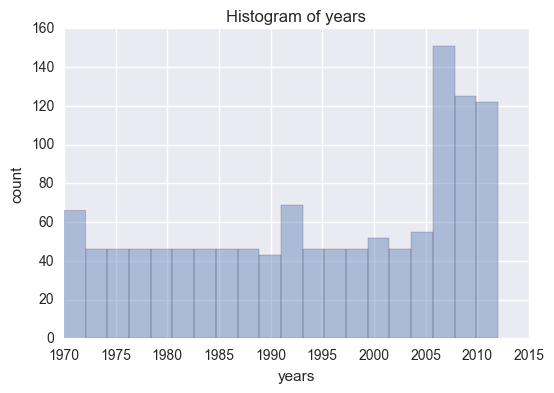

In [7]:
%matplotlib inline
if button_plots.value:
    DataVisualizations.distPlot(overall_data['year'],\
                                'Histogram of years','years','count',20,False)

### 2.3 Checking distrubution of the label visually

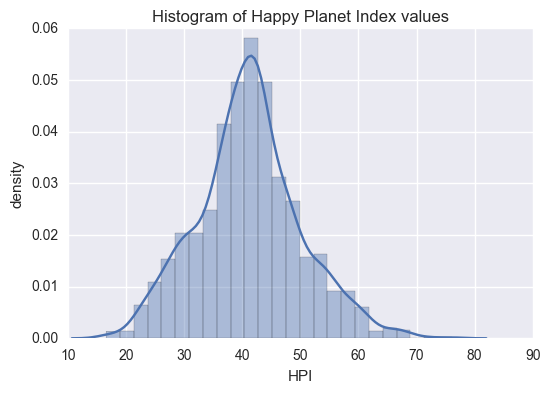

In [8]:
%matplotlib inline
if button_plots.value:
    DataVisualizations.distPlot(overall_data['Happy Planet Index'],\
                                'Histogram of Happy Planet Index values','HPI','density',25,True)

### 2.4 Most feature-target Correlated features in the data

In [9]:
HPI_correlation = overall_data[overall_data.columns[1:-1]].apply\
    (lambda x: x.corr(overall_data['Happy Planet Index'], method='spearman'))
HPI_correlation = HPI_correlation.abs().sort_values(ascending=False)
HPI_correlation = pd.DataFrame({'Feature':HPI_correlation.index,\
                                'Correlation to Happy Planet Index':HPI_correlation.values})
HPI_correlation.head(5)

,Correlation to Happy Planet Index,Feature
0,0.244313,"Population, ages 15-64, female"
1,0.242787,Population of the official age for pre-primary...
2,0.242299,Population of the official age for pre-primary...
3,0.241668,Population of the official age for pre-primary...
4,0.241227,"Population, ages 15-64, total"


### 2.5 Plot Correlation matrix, taken 2 positive and 2 negative most correlated features

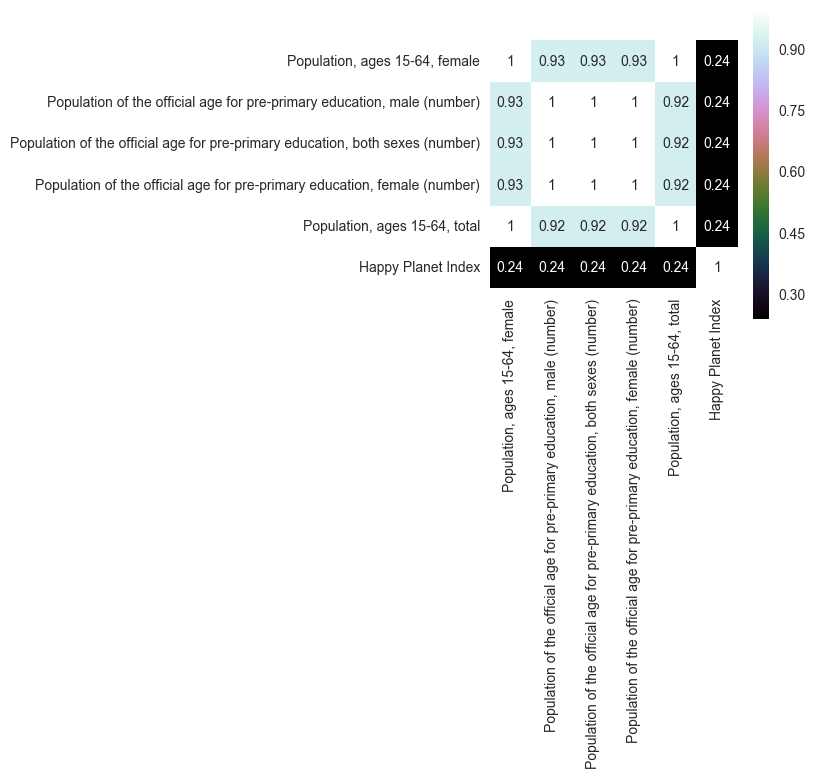

In [10]:
%matplotlib inline
corr_features = HPI_correlation['Feature'].head(5).tolist() + ['Happy Planet Index']
corr_features = [x for x in corr_features if x != 'year']
overall_data_to_plot = overall_data[corr_features]
data_corr_mat= overall_data_to_plot.corr(method='spearman')
if button_plots.value:
    plt.figure(figsize=(4,4))
    sns.heatmap(data_corr_mat, vmax=1, square=True, annot=True, cmap='cubehelix')

### 2.6 Plotting Data on world map
#### Choose between Happy Planet Index and most correlated features 
#### Unfortunatly, there is no imagination between the plots

In [11]:
if button_plots.value:
    MapVisualizations.interactMaps(overall_data,corr_features)

Please choose an option


### 2.7 Plotting boxplot of most correlated feature

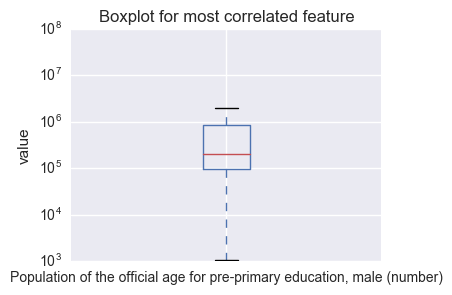

In [12]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
overall_data[corr_features[1]].to_frame().boxplot()
ax.set_yscale('log')
plt.ylabel('value')
plt.title('Boxplot for most correlated feature')

## 3. Preprocessing

### 3.1 Impute nulls with medians

In [13]:
overall_data = overall_data.fillna(overall_data.median())
overall_data.head(5)

,country,year,"Enrolment in primary education, both sexes (number)","Enrolment in primary education, female (number)",GDP at market prices (constant 2005 US$),GDP at market prices (current US$),GDP per capita (constant 2005 US$),GDP per capita (current US$),GNI (current US$),"GNI per capita, Atlas method (current US$)",...,"Population, male (% of total)","Population, total","School life expectancy, primary, both sexes (years)","School life expectancy, primary, female (years)","School life expectancy, primary, gender parity index (GPI)","School life expectancy, primary, male (years)",Theoretical duration of pre-primary education (years),Theoretical duration of primary education (years),Theoretical duration of secondary education (years),Happy Planet Index
0,Afghanistan,2012.0,5767543.0,2348306.0,1.935220e+10,2.053654e+10,651.001852,690.842629,2.157185e+10,720.0,...,51.435962,29726803.0,6.53571,5.47000,0.72495,7.54532,4.0,6.0,6.0,36.8
2,Albania,2006.0,222402.0,107004.0,9.771760e+09,8.992642e+09,3265.365622,3005.012903,9.254605e+09,3090.0,...,50.260019,2992547.0,3.98375,3.97433,0.99544,3.99253,3.0,4.0,8.0,42.1
3,Albania,2009.0,236102.0,112399.0,1.150029e+10,1.204421e+10,3928.340828,4114.136545,1.185274e+10,4280.0,...,50.432577,2927519.0,4.80613,4.74382,0.97524,4.86425,3.0,5.0,7.0,47.9
4,Albania,2012.0,206617.0,97583.0,1.240477e+10,1.231978e+10,4277.143310,4247.839852,1.222802e+10,4360.0,...,50.128703,2900247.0,5.16259,5.09023,0.97326,5.23009,3.0,5.0,7.0,54.1
6,Algeria,2006.0,4196580.0,1973901.0,1.446470e+11,1.170270e+11,4285.934521,3467.544740,1.126050e+11,3100.0,...,50.489699,33749328.0,6.40438,6.17532,0.93223,6.62422,1.0,6.0,6.0,45.9


### 3.2 One Hot Encoding Foreach Country

In [14]:
overall_data_countries = overall_data['country']
oh_overall_data = overall_data.drop('country', axis=1)
onehot_overall_col = pd.get_dummies(overall_data['country'], prefix='country')

#check for missing cols in onehot_overall_col
for col in onehot_overall_col.columns:
    if col not in onehot_overall_col.columns:
        onehot_overall_col[col] = 0
        
oh_overall_data = pd.concat([oh_overall_data, onehot_overall_col], axis=1)
overall_data = oh_overall_data
overall_data['country'] = overall_data_countries
overall_data.head(5)

,year,"Enrolment in primary education, both sexes (number)","Enrolment in primary education, female (number)",GDP at market prices (constant 2005 US$),GDP at market prices (current US$),GDP per capita (constant 2005 US$),GDP per capita (current US$),GNI (current US$),"GNI per capita, Atlas method (current US$)","Gross enrolment ratio, primary, both sexes (%)",...,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Vietnam,country_Zambia,country_Zimbabwe,country
0,2012.0,5767543.0,2348306.0,1.935220e+10,2.053654e+10,651.001852,690.842629,2.157185e+10,720.0,108.928520,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Afghanistan
2,2006.0,222402.0,107004.0,9.771760e+09,8.992642e+09,3265.365622,3005.012903,9.254605e+09,3090.0,99.593842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Albania
3,2009.0,236102.0,112399.0,1.150029e+10,1.204421e+10,3928.340828,4114.136545,1.185274e+10,4280.0,97.525330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Albania
4,2012.0,206617.0,97583.0,1.240477e+10,1.231978e+10,4277.143310,4247.839852,1.222802e+10,4360.0,104.784393,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Albania
6,2006.0,4196580.0,1973901.0,1.446470e+11,1.170270e+11,4285.934521,3467.544740,1.126050e+11,3100.0,108.287209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Algeria


### 3.3 Split Data randomly into training set and test set

In [15]:
train_data, test_data = train_test_split\
(overall_data, test_size = 0.2, random_state=0)
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
train_data.head(5)

,year,"Enrolment in primary education, both sexes (number)","Enrolment in primary education, female (number)",GDP at market prices (constant 2005 US$),GDP at market prices (current US$),GDP per capita (constant 2005 US$),GDP per capita (current US$),GNI (current US$),"GNI per capita, Atlas method (current US$)","Gross enrolment ratio, primary, both sexes (%)",...,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Vietnam,country_Zambia,country_Zimbabwe,country
0,2009.0,406920.0,200909.0,1.063964e+10,8.876191e+09,4943.249801,4123.939997,8.708821e+09,4120.0,108.228012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Namibia
1,1985.0,420665.0,205210.0,6.420870e+10,2.129391e+10,18147.884040,6018.489552,1.983712e+10,5630.0,95.102722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ireland
2,1984.0,888440.0,430238.0,1.813080e+11,4.802002e+10,18321.674990,4852.565728,4.851687e+10,5130.0,105.983048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Greece
3,1991.0,2820497.0,1366826.0,8.954290e+11,5.755990e+11,22995.652240,14782.038900,5.713820e+11,13720.0,105.279709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Spain
4,2006.0,364263.0,161875.0,2.179437e+09,1.211162e+09,506.323083,281.375017,1.202459e+09,280.0,68.011917,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Eritrea


### 3.4 Partition factors, class and countries

In [16]:
train_countries = train_data['country']
train_class = train_data['Happy Planet Index']
train_factors = (train_data.drop(['Happy Planet Index', 'country'], axis=1))

test_countries = test_data['country']
test_class = test_data['Happy Planet Index']
test_factors =(test_data.drop(['Happy Planet Index', 'country'], axis=1))

train_factors.head(5)

,year,"Enrolment in primary education, both sexes (number)","Enrolment in primary education, female (number)",GDP at market prices (constant 2005 US$),GDP at market prices (current US$),GDP per capita (constant 2005 US$),GDP per capita (current US$),GNI (current US$),"GNI per capita, Atlas method (current US$)","Gross enrolment ratio, primary, both sexes (%)",...,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Vietnam,country_Zambia,country_Zimbabwe
0,2009.0,406920.0,200909.0,1.063964e+10,8.876191e+09,4943.249801,4123.939997,8.708821e+09,4120.0,108.228012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1985.0,420665.0,205210.0,6.420870e+10,2.129391e+10,18147.884040,6018.489552,1.983712e+10,5630.0,95.102722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1984.0,888440.0,430238.0,1.813080e+11,4.802002e+10,18321.674990,4852.565728,4.851687e+10,5130.0,105.983048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1991.0,2820497.0,1366826.0,8.954290e+11,5.755990e+11,22995.652240,14782.038900,5.713820e+11,13720.0,105.279709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2006.0,364263.0,161875.0,2.179437e+09,1.211162e+09,506.323083,281.375017,1.202459e+09,280.0,68.011917,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.5 Binning The Years by Decades

In [17]:
min_year = min(min(train_factors['year']), min(test_factors['year']))
train_factors['year'] = train_factors['year'].apply(lambda x:math.floor((x-min_year) / 10))
test_factors['year'] = test_factors['year'].apply(lambda x:math.floor((x-min_year) / 10))
train_factors.head(5)

,year,"Enrolment in primary education, both sexes (number)","Enrolment in primary education, female (number)",GDP at market prices (constant 2005 US$),GDP at market prices (current US$),GDP per capita (constant 2005 US$),GDP per capita (current US$),GNI (current US$),"GNI per capita, Atlas method (current US$)","Gross enrolment ratio, primary, both sexes (%)",...,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Vietnam,country_Zambia,country_Zimbabwe
0,3,406920.0,200909.0,1.063964e+10,8.876191e+09,4943.249801,4123.939997,8.708821e+09,4120.0,108.228012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,420665.0,205210.0,6.420870e+10,2.129391e+10,18147.884040,6018.489552,1.983712e+10,5630.0,95.102722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,888440.0,430238.0,1.813080e+11,4.802002e+10,18321.674990,4852.565728,4.851687e+10,5130.0,105.983048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,2820497.0,1366826.0,8.954290e+11,5.755990e+11,22995.652240,14782.038900,5.713820e+11,13720.0,105.279709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,364263.0,161875.0,2.179437e+09,1.211162e+09,506.323083,281.375017,1.202459e+09,280.0,68.011917,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.6 Change all numeric values' datatypes to float

In [18]:
train_factors = train_factors.astype(np.float)
test_factors = test_factors.astype(np.float)
train_factors.dtypes[:5]

year                                                   float64
Enrolment in primary education, both sexes (number)    float64
Enrolment in primary education, female (number)        float64
GDP at market prices (constant 2005 US$)               float64
GDP at market prices (current US$)                     float64
dtype: object

### 3.7 Creating a yearless and countryless copies of the data
#### Henceforth, we duplicate our actions handling the data for each copy 

In [19]:
alternative_models = AlternativeModel.createAlternativeModels\
    (train_data, train_factors, train_class, train_countries, test_data, test_factors,\
                                       test_class, test_countries)

### 3.8 Data linearity proving

Applying OLS on train data and checking model assumptions
train R^2: 0.8641 
Residuals appear to behave randomly, it suggests that the linear model fits the data well:


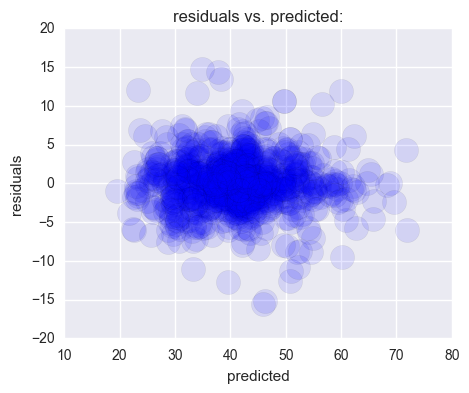

Residuals appear to be normally distributed:


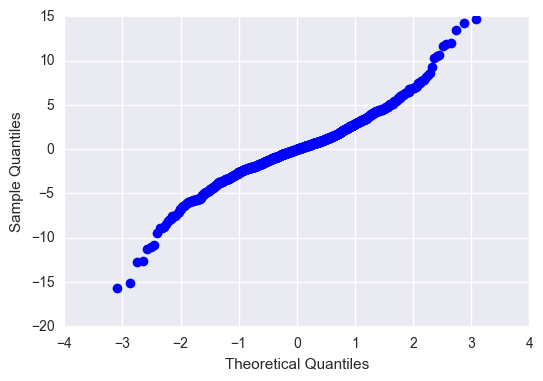

In [20]:
interact(OutliersDetection.allDataLinearityProving,\
             request=RadioButtons(options=  types_for_interact,\
                                  description='Select data type:', disabled=False))

### 3.9 Scaling nomeric features

In [21]:
for data in data_types:
    alternative_models[data].train_factors = \
            pd.DataFrame(sp.StandardScaler().fit_transform(alternative_models[data].train_factors),columns =\
                                          alternative_models[data].train_factors.columns)
    alternative_models[data].test_factors = \
            pd.DataFrame(sp.StandardScaler().fit_transform(alternative_models[data].test_factors),columns =\
                                          alternative_models[data].test_factors.columns)
AlternativeModel.updateAlternativeModels(alternative_models)
alternative_models['main data'].train_factors.head(5)

,year,"Enrolment in primary education, both sexes (number)","Enrolment in primary education, female (number)",GDP at market prices (constant 2005 US$),GDP at market prices (current US$),GDP per capita (constant 2005 US$),GDP per capita (current US$),GNI (current US$),"GNI per capita, Atlas method (current US$)","Gross enrolment ratio, primary, both sexes (%)",...,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Vietnam,country_Zambia,country_Zimbabwe
0,0.780879,-0.287638,-0.296172,-0.514255,-0.378689,-1.064374,-0.728401,-0.374095,-0.745905,0.612859,...,-0.063758,-0.045038,-0.176961,-0.055188,-0.055188,-0.045038,-0.03183,-0.063758,-0.03183,-0.055188
1,-0.782461,-0.286277,-0.295247,-0.471274,-0.367663,-0.355682,-0.598975,-0.364349,-0.637493,-0.809469,...,-0.063758,-0.045038,-0.176961,-0.055188,-0.055188,-0.045038,-0.03183,-0.063758,-0.03183,-0.055188
2,-0.782461,-0.239970,-0.246859,-0.377320,-0.343932,-0.346354,-0.678625,-0.339231,-0.673391,0.369583,...,-0.063758,-0.045038,-0.176961,-0.055188,-0.055188,-0.045038,-0.03183,-0.063758,-0.03183,-0.055188
3,-0.000791,-0.048709,-0.045464,0.195653,0.124527,-0.095502,-0.000298,0.118704,-0.056662,0.293365,...,-0.063758,-0.045038,-0.176961,-0.055188,-0.055188,-0.045038,-0.03183,-0.063758,-0.03183,-0.055188
4,0.780879,-0.291860,-0.304565,-0.521043,-0.385495,-1.302503,-0.990904,-0.380670,-1.021603,-3.745178,...,-0.063758,-0.045038,-0.176961,-0.055188,-0.055188,-0.045038,-0.03183,-0.063758,-0.03183,-0.055188


## 4. Outliers Detection

### 4.1 Robust Regression Method

• Validation R^2 before outliers' removal, 0.9128 

• 44 rows were dropped

• Validation R^2 after outliers' removal, 0.9561 



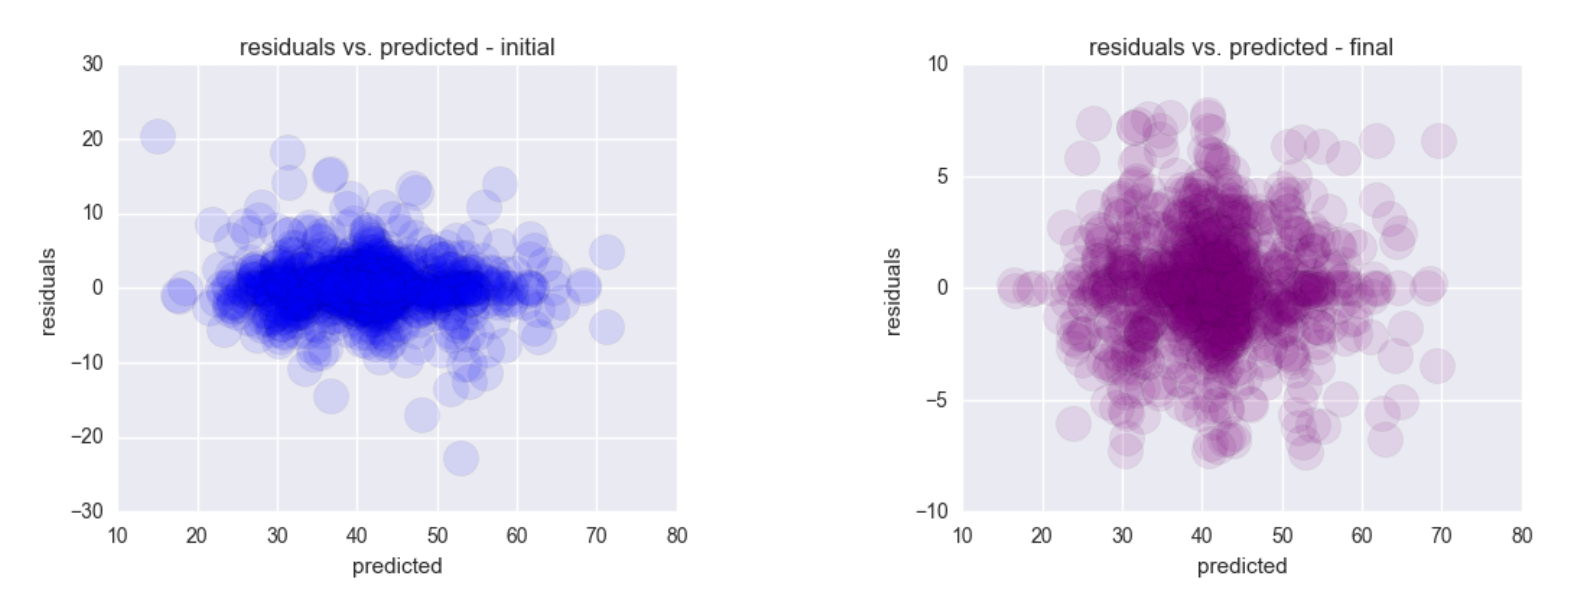

In [22]:
f = FloatProgress(min=0, max=100)
display(f)
for data in data_types:
    alternative_models[data].train_factors, alternative_models[data].\
        train_class, alternative_models[data].train_data =\
                                OutliersDetection.removeOutliersRlm(alternative_models[data].train_factors, \
                                                                    alternative_models[data].train_class, \
                                                                alternative_models[data].train_data, 1,data)
    f.value += 33
    
AlternativeModel.updateAlternativeModels(alternative_models)
f.value += 1

interact(OutliersDetection.showResidualsRemoval,\
             request=RadioButtons(options=  types_for_interact,\
                                  description='Select data type:', disabled=False))

### 4.2 PCA Visual Method

#### 4.2.1 Apply 2D-PCA dimension reduction for visual outliers detection 

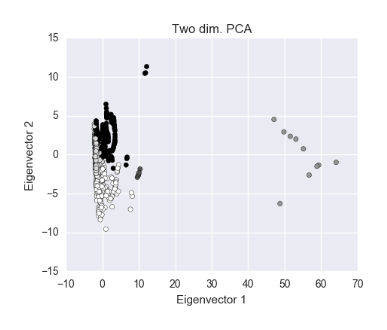

In [23]:
PCAAltModels = dict([(data,(OutliersDetection.\
                            twoDimPCAandClustering(alternative_models[data].train_factors,data))) \
                                 for data in data_types])
AlternativeModel.updateAlternativeModels(alternative_models)

interact(OutliersDetection.allDataTwoDimPCAandClustering,\
             request=RadioButtons(options=  types_for_interact,\
                                  description='Select data type:', disabled=False))

#### 4.2.2 Print outliers' countries

In [24]:
outliers_indecies_alternative_model = dict([(data,np.where(PCAAltModels[data][0][:,0] > 20)[0].tolist()) \
                                            for data in data_types])
outliers_df_alternative_model = dict([(data,alternative_models[data].train_data.loc\
                                       [outliers_indecies_alternative_model[data], :]) for data \
                                             in data_types])
OutliersDetection.printOutlierCountries(outliers_df_alternative_model,outliers_indecies_alternative_model)

Please choose an option


#### 4.2.3 Remove visible outliers if reducing aquracy

In [25]:
f = FloatProgress(min=0, max=100)
display(f)
f.value += 1
for data in data_types:
    print("• ",data,"run:")
    alternative_models[data].train_factors, alternative_models[data].\
            train_class, alternative_models[data].train_data =\
                                OutliersDetection.removeOutliersPCA(alternative_models[data].train_factors,\
                                                                    alternative_models[data].train_class,\
                                                                    alternative_models[data].train_data,\
                                                                    outliers_indecies_alternative_model[data])
    f.value += 33
AlternativeModel.updateAlternativeModels(alternative_models)

•  main data run:
	R^2 on validation set with outliers: 0.904946241467 , and without outliers: 0.910812702711
	Leaving outliers in the training set, did not exceed 0.3 threshold in the difference between the R^2s. 

•  no countries run:
	R^2 on validation set with outliers: 0.410568418316 , and without outliers: 0.458319744672
	Removing outliers from training set. 

•  no years run:
	R^2 on validation set with outliers: 0.900838982776 , and without outliers: 0.905329255707
	Leaving outliers in the training set, did not exceed 0.3 threshold in the difference between the R^2s. 



## 5. Feature selection with E.Net model

### 5.1 Feature selection

In [26]:
chosen_features_and_coefs_alternative_models = dict([(data,"") for data in data_types])
table_alternative_models = dict([(data,"") for data in data_types])

f = FloatProgress(min=0, max=100)
display(f)
f.value += 1
for data in data_types:
    chosen_features_and_coefs_alternative_models[data], table_alternative_models[data] =\
                                FeatureSelection.featureSelectionWithENET(alternative_models[data].train_factors,\
                                                                    alternative_models[data].train_class)
    f.value += 33
AlternativeModel.updateAlternativeModels(alternative_models)

FeatureSelection.printStrongCoeffs(table_alternative_models)

Please choose an option


### 5.2 Countries correlated to target plot

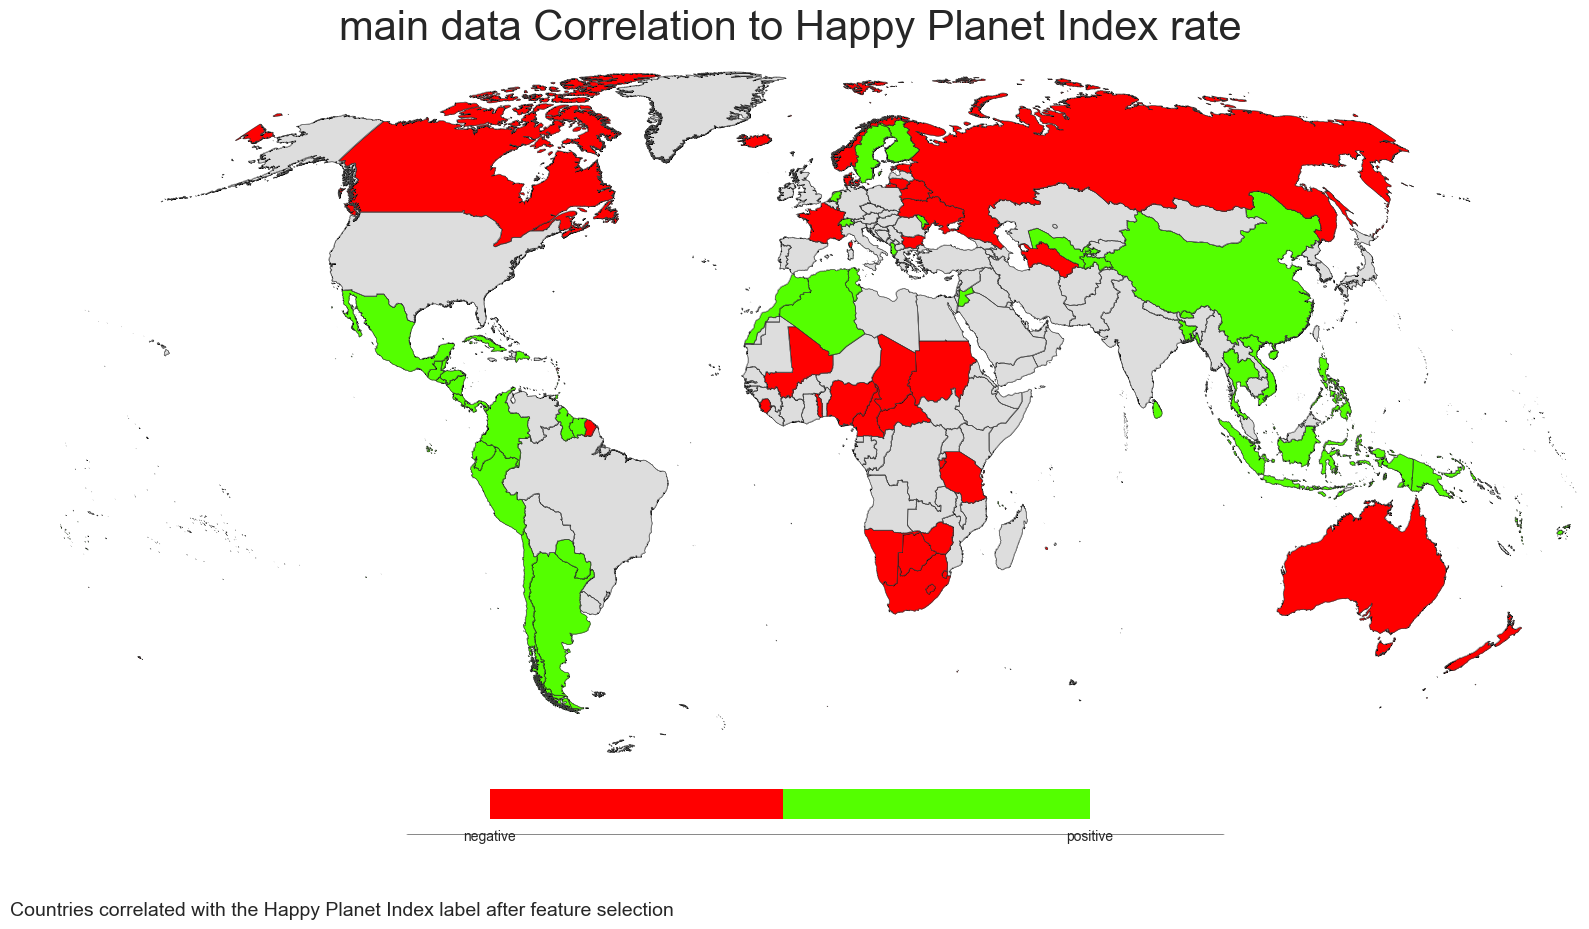

In [27]:
FeatureSelection.countriesCorrMap(chosen_features_and_coefs_alternative_models)

### 5.3 Take remaining features

In [28]:
for data in data_types:
    chosen_features = [x[0] for x in chosen_features_and_coefs_alternative_models[data]]
    alternative_models[data].train_factors = alternative_models[data].train_factors[chosen_features]
    alternative_models[data].test_factors = alternative_models[data].test_factors[chosen_features]

## 6. Features extraction
#### Checking feature interactions' correlations to label - done only for main data type

### 6.1 Synthesizing features' interactions

In [29]:
poly = sp.PolynomialFeatures(2, include_bias=False)
transf_train = poly.fit_transform(train_factors)
transf_test = poly.fit_transform(test_factors)
target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) \
                                  for pair in tuple if pair[1]!=0]) for tuple in [zip(train_factors.columns,p) \
                                                                                  for p in poly.powers_]]
train_factors_after_extracion = (pd.DataFrame(transf_train, columns = target_feature_names))
test_factors_after_extracion = (pd.DataFrame(transf_test, columns = target_feature_names))
train_factors_after_extracion.head(5)

,year^1,"Enrolment in primary education, both sexes (number)^1","Enrolment in primary education, female (number)^1",GDP at market prices (constant 2005 US$)^1,GDP at market prices (current US$)^1,GDP per capita (constant 2005 US$)^1,GDP per capita (current US$)^1,GNI (current US$)^1,"GNI per capita, Atlas method (current US$)^1","Gross enrolment ratio, primary, both sexes (%)^1",...,country_Vanuatu^2,country_Vanuatu^1xcountry_Vietnam^1,country_Vanuatu^1xcountry_Zambia^1,country_Vanuatu^1xcountry_Zimbabwe^1,country_Vietnam^2,country_Vietnam^1xcountry_Zambia^1,country_Vietnam^1xcountry_Zimbabwe^1,country_Zambia^2,country_Zambia^1xcountry_Zimbabwe^1,country_Zimbabwe^2
0,3.0,406920.0,200909.0,1.063964e+10,8.876191e+09,4943.249801,4123.939997,8.708821e+09,4120.0,108.228012,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,420665.0,205210.0,6.420870e+10,2.129391e+10,18147.884040,6018.489552,1.983712e+10,5630.0,95.102722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,888440.0,430238.0,1.813080e+11,4.802002e+10,18321.674990,4852.565728,4.851687e+10,5130.0,105.983048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,2820497.0,1366826.0,8.954290e+11,5.755990e+11,22995.652240,14782.038900,5.713820e+11,13720.0,105.279709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,364263.0,161875.0,2.179437e+09,1.211162e+09,506.323083,281.375017,1.202459e+09,280.0,68.011917,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 6.2 Checking correlations between target and synthesized features

In [30]:
poly = sp.PolynomialFeatures(2, include_bias=False)
transf_train = poly.fit_transform(train_factors)
target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0])\
                        for tuple in [zip(train_factors.columns,p) for p in poly.powers_]]
train_factors_after_extracion = (pd.DataFrame(transf_train, columns = target_feature_names))

max_corr_before = HPI_correlation['Correlation to Happy Planet Index'].iloc[0]
HPI_correlation_feature_extraction = train_factors_after_extracion[train_factors_after_extracion.columns[:]].apply\
(lambda x: x.corr(train_data['Happy Planet Index'], method='spearman'))
HPI_correlation_feature_extraction = HPI_correlation_feature_extraction.abs().sort_values(ascending=False)
HPI_correlation_feature_extraction = pd.DataFrame({'Feature':HPI_correlation_feature_extraction.index,\
                                'Correlation to Happy Planet Index':HPI_correlation_feature_extraction.values})
HPI_correlation_feature_extraction = HPI_correlation_feature_extraction.loc\
[(HPI_correlation_feature_extraction["Correlation to Happy Planet Index"] > max_corr_before) \
 & ((HPI_correlation_feature_extraction["Feature"].\
     str.count("\^") == 2) | ((HPI_correlation_feature_extraction["Feature"].str.count("\^2") == 1)))]
print('There are', HPI_correlation_feature_extraction.shape[0],\
      'new features that are more correlative to target then \
      old features and many other new very correlative features')
HPI_correlation_feature_extraction.head(5)

There are 460 new features that are more correlative to target then       old features and many other new very correlative features


,Correlation to Happy Planet Index,Feature
0,0.273763,"year^1xPopulation, ages 15-64, female^1"
1,0.273307,year^1xPopulation of the official age for uppe...
2,0.272771,"Population, ages 15-64, female^1xTheoretical d..."
3,0.272517,year^1xPopulation of the official age for uppe...
4,0.272433,GNI (current US$)^1xPopulation of the official...


## 7. Model - Kernel ridge regression

#### We use this model with the kernel trick due to the positive results of section 6.2

In [31]:
param_grid_for_kridge = {'alpha': [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12],\
              'gamma': [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12]}
model = GridSearchCV(KernelRidge(kernel='polynomial', degree=2),\
                     cv=5, param_grid=param_grid_for_kridge, n_jobs=-1, verbose=1)

kernel_ridge_results = dict([(data,ResultsMeasurements(button_exec.value, alternative_models[data].train_data,\
                            alternative_models[data].test_data,alternative_models[data].train_factors,\
                                alternative_models[data].test_factors,alternative_models[data].train_class,\
                                    alternative_models[data].test_class,model,'kernel ridge resgression '+data))\
                                       for data in data_types])
tab = ResultsMeasurements.tabDisplay(kernel_ridge_results)
tab

Please choose an option from the bar above


## 8. Model Evaluation

### 8.1 Linear Regression

In [32]:
lr = LinearRegression()
linear_regression_results = dict([(data,ResultsMeasurements(button_exec.value, alternative_models[data].train_data,\
                            alternative_models[data].test_data,alternative_models[data].train_factors,\
                                    alternative_models[data].test_factors,alternative_models[data].train_class,\
                                            alternative_models[data].test_class,lr,'linear regression '+data))\
                                               for data in data_types])
tab = ResultsMeasurements.tabDisplay(linear_regression_results)
tab

Please choose an option from the bar above


### 8.2 Ridge Regression

In [33]:
ridge = Ridge(alpha=1.0)
ridge_regression_results = dict([(data,ResultsMeasurements(button_exec.value, alternative_models[data].train_data,\
                                alternative_models[data].test_data,alternative_models[data].train_factors,\
                                        alternative_models[data].test_factors,alternative_models[data].train_class,\
                                                alternative_models[data].test_class,ridge,'ridge resgression '+data))\
                                                   for data in data_types])
tab = ResultsMeasurements.tabDisplay(ridge_regression_results)
tab

R^2 for Train data = 0.869071385213
R^2 for Test data = 0.615269703456


### 8.3 Random Forest
#### The Random Forest model presents better results on the data, and therefore we will use it instead of the kernel ridge

In [34]:
param_grid_for_random_forest = {'max_features': [None, 'sqrt', 'log2'],\
                    'n_estimators': [500, 1000, 1500], 'max_depth': [None, 1, 5, 10, 50], 'min_samples_split':\
                    [2, 3, 4, 5], 'min_samples_leaf':[1, 3, 5, 7, 9]}
clf = GridSearchCV(RandomForestRegressor(), param_grid=param_grid_for_random_forest, cv=5,
                  n_jobs=-1, verbose=1)
random_forest_results = dict([(data,ResultsMeasurements(button_exec.value, alternative_models[data].train_data,\
                            alternative_models[data].test_data,alternative_models[data].train_factors,\
                                    alternative_models[data].test_factors,alternative_models[data].train_class,\
                                        alternative_models[data].test_class,clf,'random forest resgression '+data))\
                                           for data in data_types])
tab = ResultsMeasurements.tabDisplay(random_forest_results)
tab

Please choose an option from the bar above


### 8.4 Numeric Results Comparison for all 4 models

In [35]:
ResultsMeasurements.compareModels(linear_regression_results, ridge_regression_results,\
                                  kernel_ridge_results,random_forest_results)

Please choose an option


## 9. The prediction of Random Forest (elected model), on the test dataset compared to label

In [36]:
ResultsMeasurements.compareLabelPredictionOnMap(random_forest_results)

Please choose an option


## 10.  Types of datasets' prediction comparison (for our elected model - Random Forest)

In [37]:
comparison_parameters = pd.DataFrame(['R^2 for Train data','R^2 for Test data','Mean HPI for Train data',\
                              'Mean pdataTypesrediction for Train data','Mean HPI for Test data',\
                                      'Mean prediction for Test data',\
                                          'Error Percentage for Train data','Error Percentage for Test data'])
for dataset in data_types:
    comparison_parameters[dataset] = random_forest_results[dataset].comparison_parameters_df
comparison_parameters.columns = ['parameter'] + data_types
display(comparison_parameters.head(10))

,parameter,main data,no countries,no years
0,R^2 for Train data,0.967862,-0.044004,0.961483
1,R^2 for Test data,0.718918,-0.103774,0.448158
2,Mean HPI for Train data,41.055932,40.815178,41.034000
3,Mean pdataTypesrediction for Train data,41.051285,41.513766,41.014139
4,Mean HPI for Test data,41.364372,41.364372,41.364372
5,Mean prediction for Test data,41.001483,40.946224,43.033926
6,Error Percentage for Train data,2.444418,14.163411,2.714507
7,Error Percentage for Test data,7.627692,17.750404,10.303969
